### [GD-8] 도로 영역을 찾자! - 세그멘테이션 모델 만들기

Step 1. KITTI 데이터셋 수집과 구축  
다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다.   그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.  
  
Step 2. U-Net++ 모델의 구현  
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한   이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.  

Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석  
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.  

0. 라이브러리 로드.

In [32]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf
import random


import PIL
import skimage
import albumentations
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import layers, Input, Model

rand_seed=100
random.seed(rand_seed)
np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0


1. 데이터 준비.

In [34]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

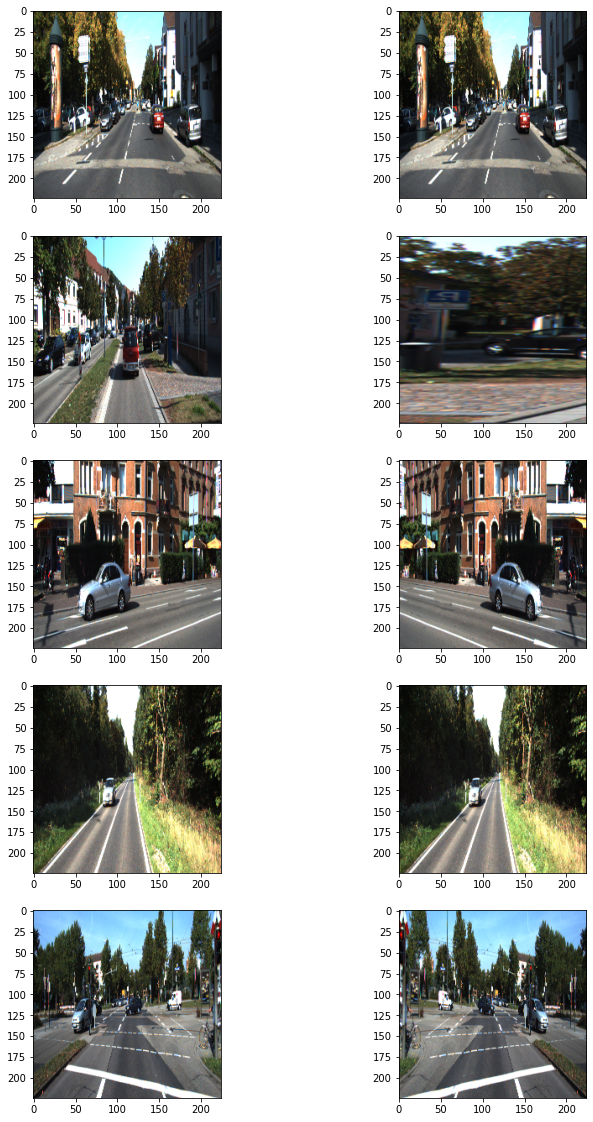

In [35]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [36]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
            dir_path,
            batch_size=1,
            img_size=(224, 224, 3),
            output_size=(224, 224),
            is_train=True,
            augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
        return self.indexes

In [37]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

2. 모델 준비.

In [38]:

def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name="x0.0")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name="x1.0")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name="x2.0")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name="x3.0")(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal', name="x4.0")(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [47]:
def contract_node(node_name, in_node, f_cnt, contract=True):

    if contract is True:
        in_node = MaxPooling2D(pool_size=(2, 2))(in_node)
        
    x = Conv2D(f_cnt, 3, activation='relu', padding='same',kernel_initializer='he_normal')(in_node)
    x = Conv2D(f_cnt, 3, activation='relu', padding='same',kernel_initializer='he_normal', name=node_name)(x)
    return x


def merge_node(node_name, in_node, up_node, f_cnt):
    x1 = Conv2DTranspose(f_cnt, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(up_node)
    x2 = concatenate([in_node, x1], axis = 3, name=node_name)
    x3 = Conv2D(f_cnt, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x2)
    x4 = Conv2D(f_cnt, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x3)
    return x4


def out_node(in_nodes):
    
    node_cnt = len(in_nodes)
    if node_cnt > 1:
        x = concatenate(in_nodes, axis = 3)
    else:
        x = in_nodes[0]

    out = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x)     
    out = Conv2D(1, 1, activation='sigmoid')(out)
    return out


def build_unetpp(input_shape=(224, 224, 3), deep=False):
    inputs = Input(input_shape)

    #Contracting Path
    x00 = contract_node("x00", inputs, 64, contract=False)
    x10 = contract_node("x10", x00, 128)
    x20 = contract_node("x20", x10, 256)
    x30 = contract_node("x30", x20, 512)
    x40 = contract_node("x40", x30, 1024)
    
    x40 = Dropout(0.5)(x40)

    #Expanding Path
    x31 = merge_node('x31', x30, x40, 512)

    x21 = merge_node('x21', x20, x30, 256)
    x22 = merge_node('x22', x21, x31, 256)

    x11 = merge_node('x11', x10, x20, 128)
    x12 = merge_node('x12', x11, x21, 128)
    x13 = merge_node('x13', x12, x22, 128)

    x01 = merge_node('x01', x00, x10, 64)
    x02 = merge_node('x02', x01, x11, 64)
    x03 = merge_node('x03', x02, x12, 64)
    x04 = merge_node('x04', x03, x13, 64)
    
    if deep is True:
        out = out_node([x01, x02, x03, x04])
    else:
        out = out_node([x04])

    model = Model(inputs = inputs, outputs = out)
    return model

In [41]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    # dice_coef
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [51]:
unet = build_unet()
unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

unetpp = build_unetpp(deep=True)
# unetpp.compile(optimizer = Adam(1e-4), loss = dice_coef)
unetpp.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')


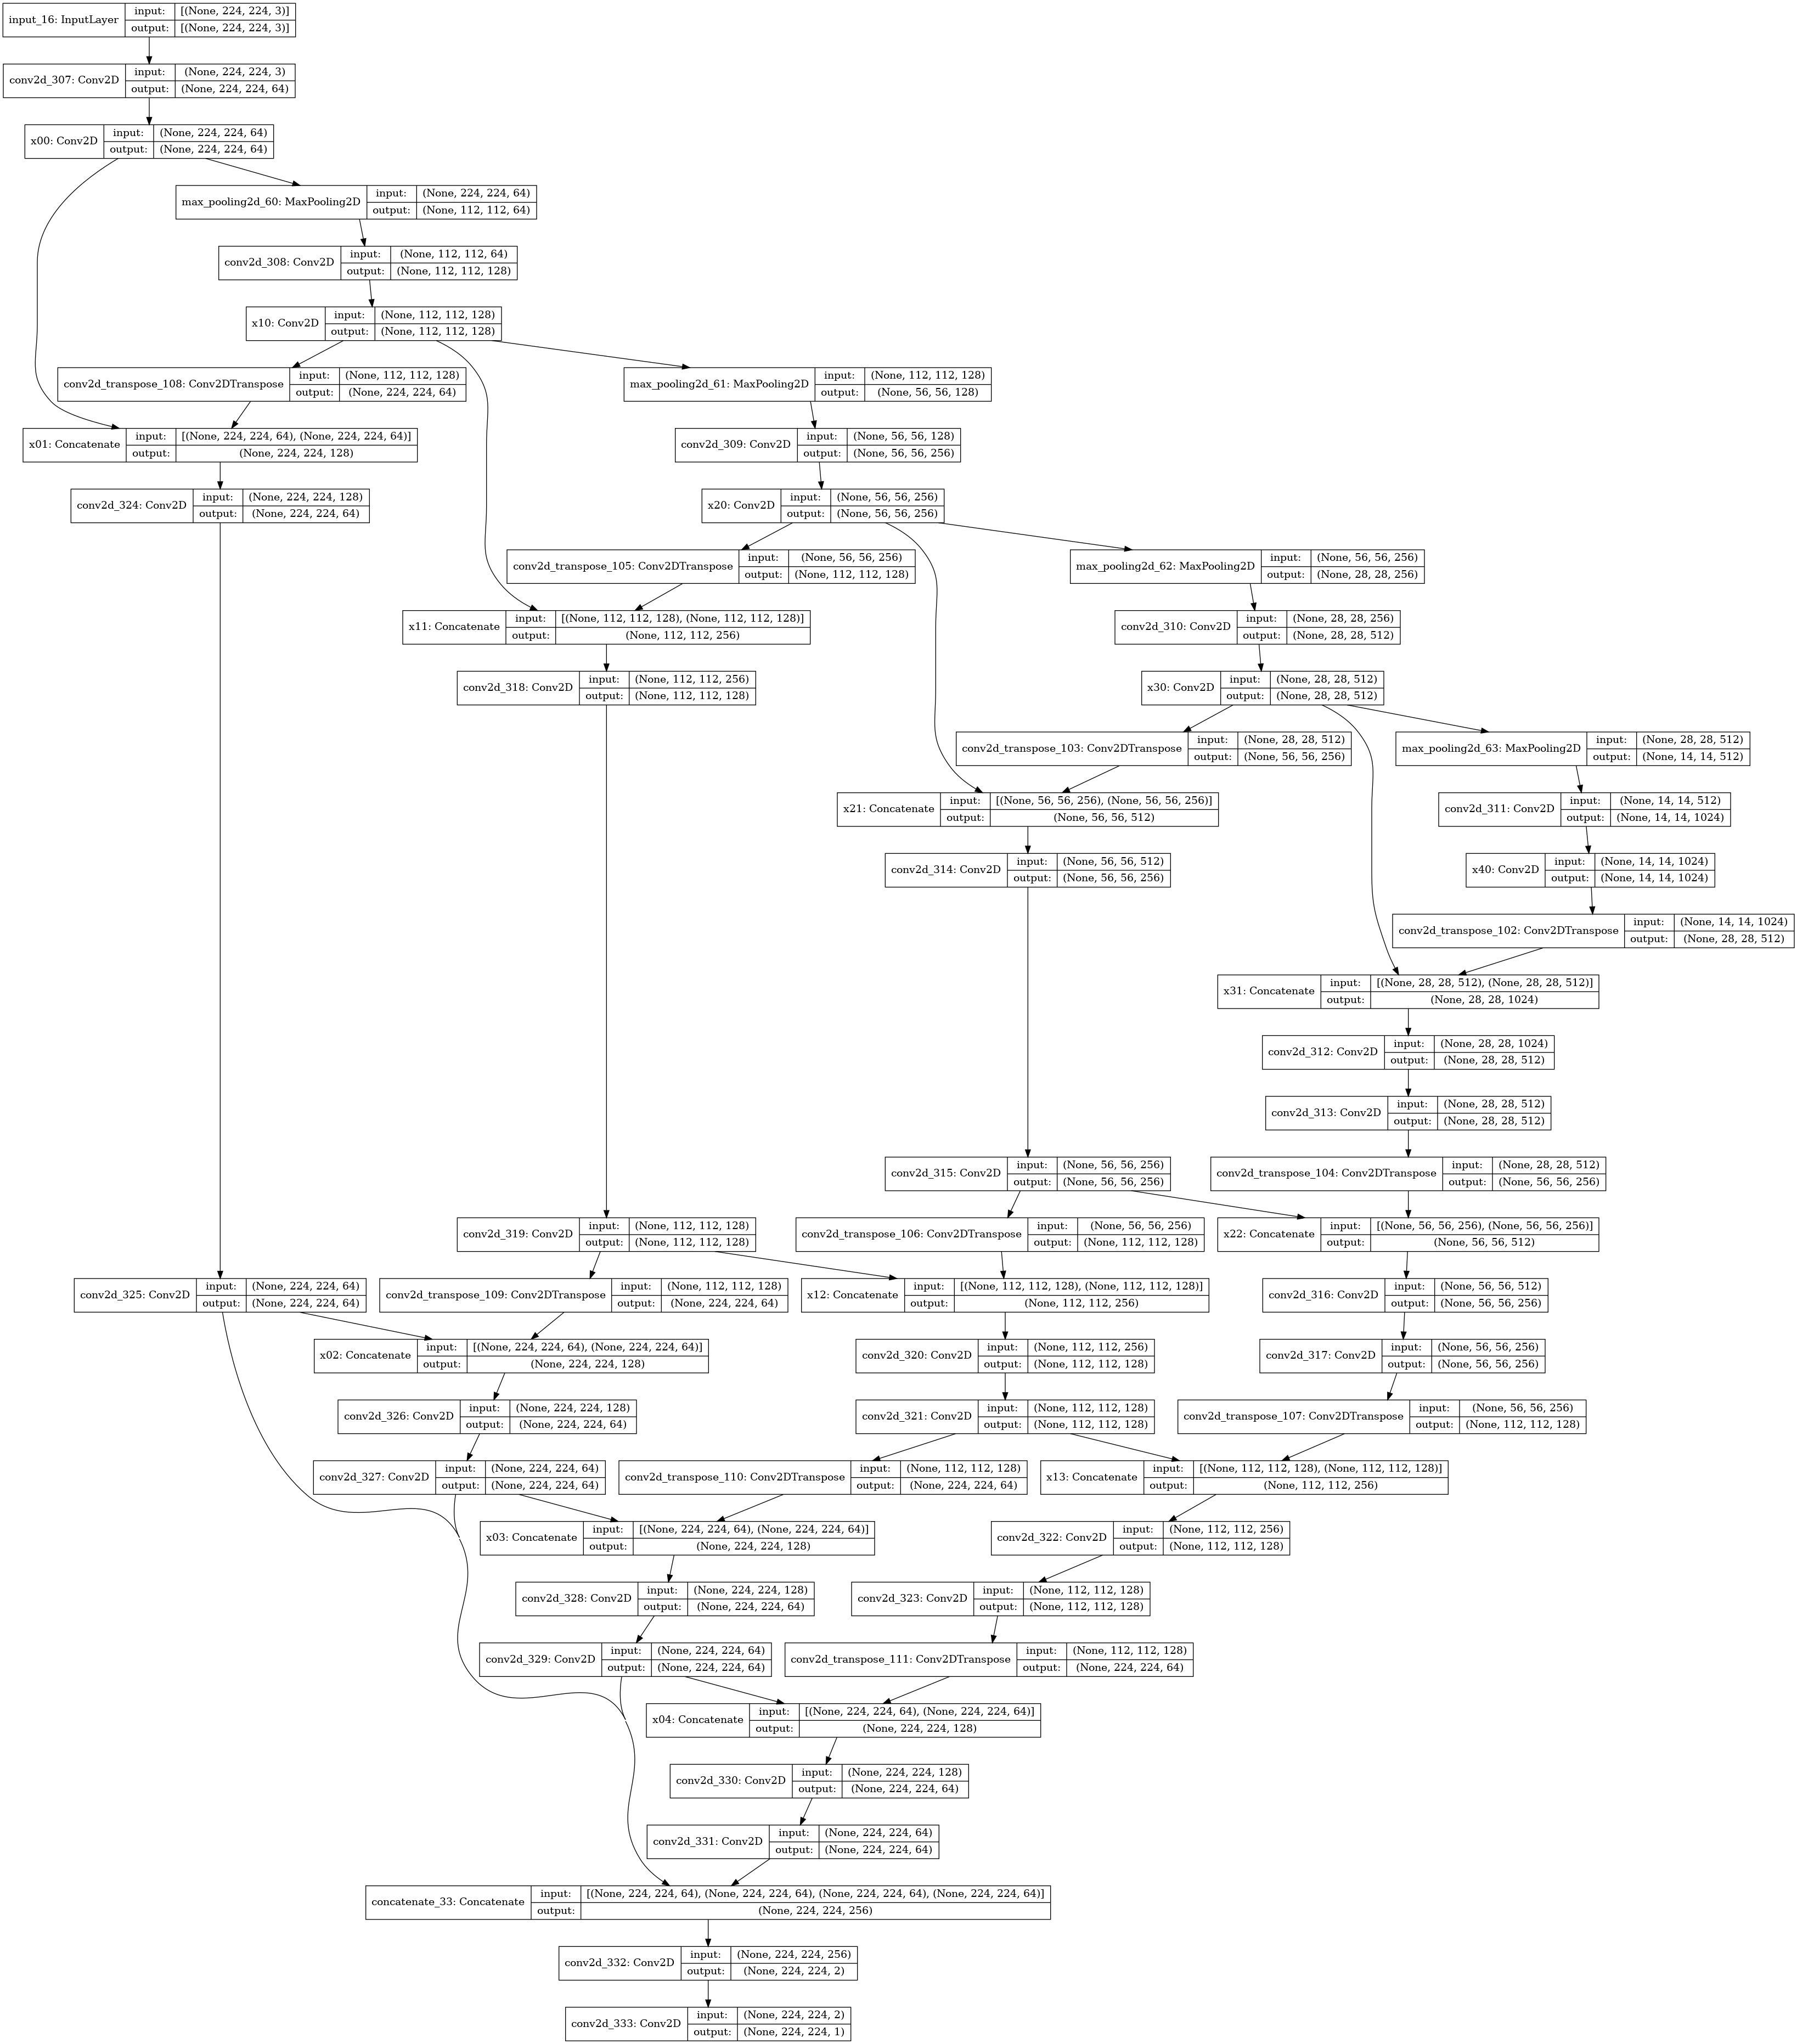

In [60]:
from tensorflow.keras.utils import plot_model

plot_model(unetpp, show_shapes=True, show_layer_names=True, expand_nested=True, show_dtype=False)

3. 모델 학습 및 테스트

In [61]:
unet_history = unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    epochs=100,
 )

Epoch 1/100
170/170 [==============================] - 15s 78ms/step - loss: 0.4756 - val_loss: 0.4255
Epoch 2/100
170/170 [==============================] - 13s 76ms/step - loss: 0.2939 - val_loss: 0.3315
Epoch 3/100
170/170 [==============================] - 13s 77ms/step - loss: 0.2546 - val_loss: 0.3295
Epoch 4/100
170/170 [==============================] - 13s 78ms/step - loss: 0.2883 - val_loss: 0.3453
Epoch 5/100
170/170 [==============================] - 13s 77ms/step - loss: 0.2784 - val_loss: 0.4070
Epoch 6/100
170/170 [==============================] - 13s 76ms/step - loss: 0.2593 - val_loss: 0.3611
Epoch 7/100
170/170 [==============================] - 13s 76ms/step - loss: 0.2504 - val_loss: 0.3128
Epoch 8/100
170/170 [==============================] - 13s 76ms/step - loss: 0.2520 - val_loss: 0.3173
Epoch 9/100
170/170 [==============================] - 13s 76ms/step - loss: 0.2316 - val_loss: 0.3478
Epoch 10/100
170/170 [==============================] - 13s 76ms/step - l

In [52]:
unetpp_history = unetpp.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    epochs=100,
 )

Epoch 1/100
170/170 [==============================] - 24s 130ms/step - loss: 0.4147 - val_loss: 0.3364
Epoch 2/100
170/170 [==============================] - 22s 129ms/step - loss: 0.2890 - val_loss: 0.2773
Epoch 3/100
170/170 [==============================] - 22s 128ms/step - loss: 0.2791 - val_loss: 0.3158
Epoch 4/100
170/170 [==============================] - 22s 127ms/step - loss: 0.2522 - val_loss: 0.3262
Epoch 5/100
170/170 [==============================] - 22s 127ms/step - loss: 0.2451 - val_loss: 0.2809
Epoch 6/100
170/170 [==============================] - 22s 127ms/step - loss: 0.2566 - val_loss: 0.2868
Epoch 7/100
170/170 [==============================] - 22s 127ms/step - loss: 0.2385 - val_loss: 0.2695
Epoch 8/100
170/170 [==============================] - 22s 127ms/step - loss: 0.2433 - val_loss: 0.2899
Epoch 9/100
170/170 [==============================] - 22s 126ms/step - loss: 0.2398 - val_loss: 0.2946
Epoch 10/100
170/170 [==============================] - 21s 126m

In [53]:
unetpp_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp'
unetpp.save(unetpp_model_path)  #학습한 모델을 저장해 주세요.

INFO:tensorflow:Assets written to: /aiffel/aiffel/semantic_segmentation/seg_model_unetpp/assets


In [54]:
model = unetpp

In [55]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output 

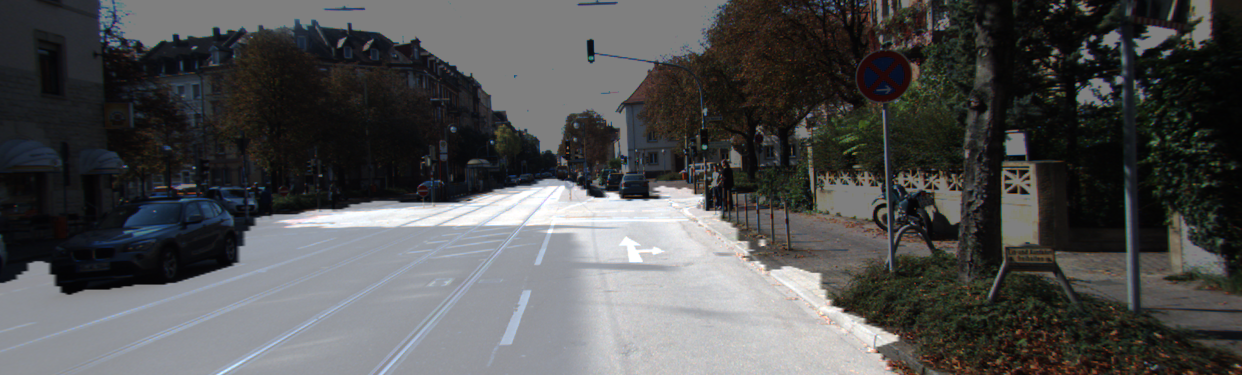

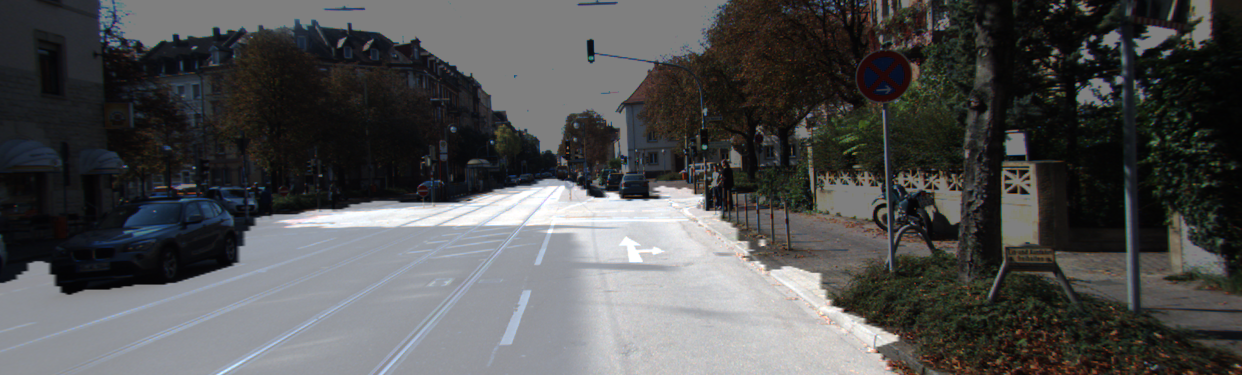

In [56]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [57]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [58]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

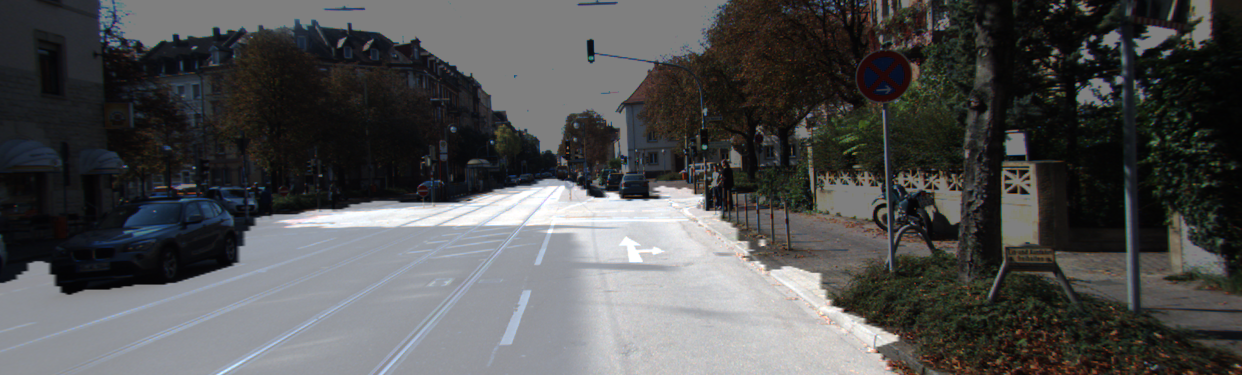

IoU : 0.928396


0.9283963455396271

In [59]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

4. unet과 비교.

In [62]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 
unet = tf.keras.models.load_model(model_path)
model = unet

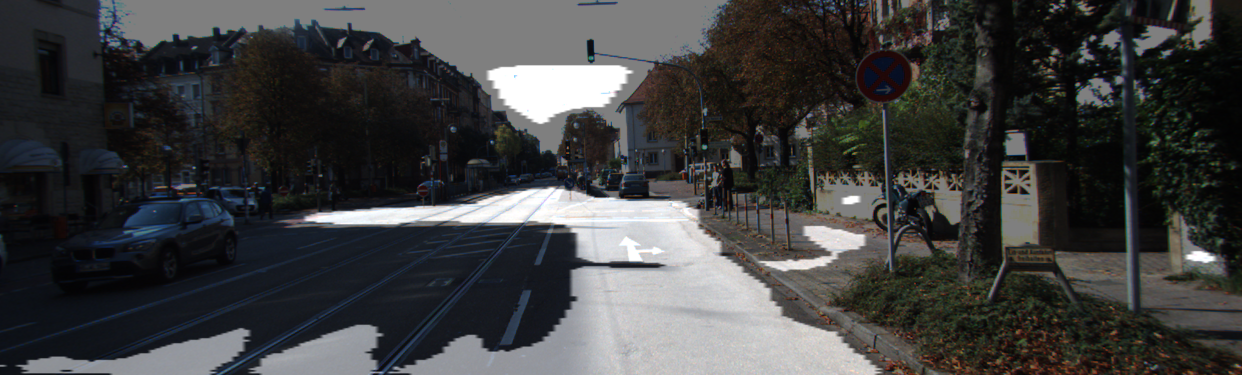

IoU : 0.419641


0.41964089410040306

In [63]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

5. 회고.  

- unet과 구현한 unet++을 비교해 보았습니다.  
- 100epoch학습한 모델에서 score가 0.419 -> 0.928로 크게 향상되었음을 알 수 있습니다.  
- 이미지 테스트에서도 road에 대한 경계가 훨씬 정확히 구분되는 것을 볼 수 있습니다.  
- feature map을 생성하고 decoding하는 경우, residual이 중요하고, 추가적으로 비선형성을 준다면 더 나은 결과를 얻을 수 있다는 것을 확인할 수 있었습니다.  
